Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, zipfile, torch, torchvision, time
import torch.nn as nn
import matplotlib.image as mpimg
from PIL import Image

from numpy.random import seed
from IPython.display import display
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from copy import deepcopy

from google.colab import files
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from warnings import filterwarnings as fw; fw("ignore")

<ipython-input-1-7fed7f5d35fd>:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Mengambil dataset dari kaggle

In [ ]:
# Install kaggle dan unduh dataset
!pip install kaggle
!mkdir -p ~/.kaggle
!kaggle datasets download -d allandclive/chicken-disease-1

# Fungsi untuk mengekstrak file zip
def extract_zip(file_path, extract_path):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Path ke file zip dan direktori ekstraksi
zip_file = 'chicken-disease-1.zip'
extract_dir = 'chicken-disease-1'

# Membuat folder ekstraksi jika belum ada
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Ekstrak file zip
extract_zip(zip_file, extract_dir)
print(f"Files extracted to: {extract_dir}")

# Hapus file zip setelah ekstraksi selesai
if os.path.exists(zip_file):
    os.remove(zip_file)
    print(f"{zip_file} has been deleted.")
else:
    print(f"{zip_file} does not exist.")

Dataset URL: https://www.kaggle.com/datasets/allandclive/chicken-disease-1
License(s): unknown
 99% 263M/266M [00:01<00:00, 192MB/s]
100% 266M/266M [00:01<00:00, 185MB/s]
Files extracted to: chicken-disease-1
chicken-disease-1.zip has been deleted.


In [ ]:
df = pd.read_csv('/content/chicken-disease-1/train_data.csv')
df

images               label
0       salmo.1558.jpg          Salmonella
1       cocci.1866.jpg         Coccidiosis
2        cocci.171.jpg         Coccidiosis
3       salmo.1484.jpg          Salmonella
4          ncd.100.jpg  New Castle Disease
...                ...                 ...
8062   healthy.935.jpg             Healthy
8063    salmo.1607.jpg          Salmonella
8064     pcrncd.70.jpg  New Castle Disease
8065    salmo.1641.jpg          Salmonella
8066  healthy.1145.jpg             Healthy

[8067 rows x 2 columns]

In [ ]:
df['label'].value_counts()

label
Salmonella            2625
Coccidiosis           2476
Healthy               2404
New Castle Disease     562
Name: count, dtype: int64

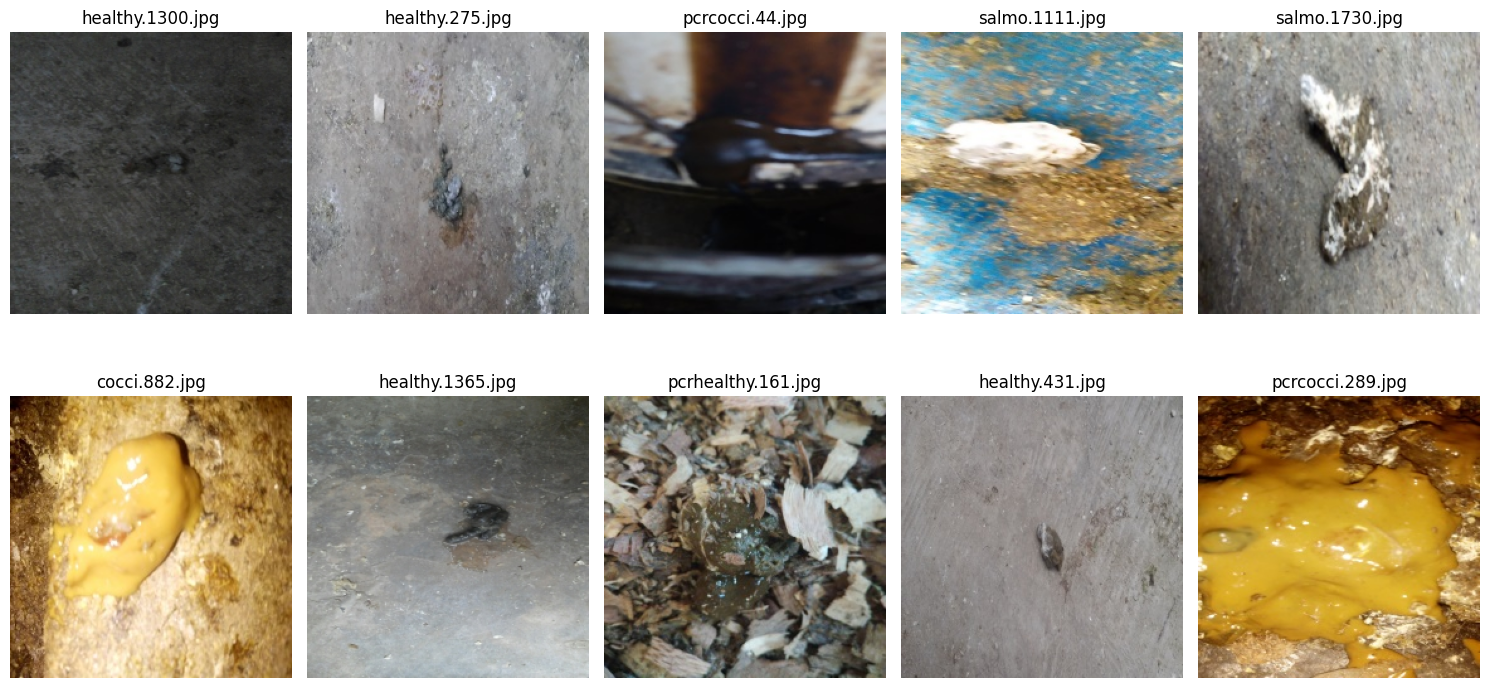

In [ ]:
folder_train = '/content/chicken-disease-1/Train'
image_train = os.listdir(folder_train)
image_train = [file for file in image_train if file.endswith('.jpg')]
selected_images = image_train[:10]

plt.figure(figsize=(15, 8))
for i, image_name in enumerate(selected_images):
    image_path = os.path.join(folder_train, image_name)
    image = mpimg.imread(image_path)

    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_name)

plt.tight_layout()
plt.show()

In [ ]:
torch.__version__ == "2.0.1+cu117"
torchvision.__version__ == "0.15.2+cu117"

False

Define seeding

In [ ]:
seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True

In [ ]:
csv_file = '/content/chicken-disease-1/train_data.csv'
train_dir = '/content/chicken-disease-1/Train'

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {
            'Healthy': 0,
            'Salmonella': 1,
            'Coccidiosis': 2,
            'New Castle Disease': 3
        }

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')  # Pastikan gambar dalam format RGB
        label_str = self.data_frame.iloc[idx, 1]
        label = self.label_map.get(label_str, -1)
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformasi khusus DenseNet
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Membuat dataset
dataset = CustomImageDataset(csv_file=csv_file, img_dir=train_dir, transform=transform)

User-defined Functions (UDFs)

In [ ]:
def get_dataloaders(train_batch_size: int, val_batch_size: int, train_dir: str, csv_file: str, val_split: float = 0.2):
    # Transformasi untuk training dan validation (khusus DenseNet)
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),  # Resize gambar ke 224x224 dengan augmentasi crop acak
        transforms.RandomHorizontalFlip(),  # Augmentasi horizontal flip
        transforms.ToTensor(),  # Konversi gambar ke tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisasi sesuai pre-trained model
    ])

    transform_valid = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize gambar ke 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisasi sesuai pre-trained model
    ])

    # Dataset training (gunakan CSV file untuk label)
    full_train_dataset = CustomImageDataset(csv_file=csv_file, img_dir=train_dir, transform=transform_train)

    # Split dataset training menjadi train dan validation
    train_size = int(0.8 * len(full_train_dataset))
    val_size = int(0.1 * len(full_train_dataset))
    test_size = len(full_train_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(
        full_train_dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=val_batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
def model_summary(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = trainable_params + non_trainable_params

    return {
        "Total Parameters": total_params,
        "Trainable Parameters": trainable_params,
        "Non-Trainable Parameters": non_trainable_params,
    }


Plot performance

In [ ]:
def plot_performance(dict_ : dict, *args, **kwargs) -> None:
    my_figure = plt.figure(figsize=(12, 4))
    # NOTE: figsize=(width/horizontally, height/vertically)

    m = my_figure.add_subplot(121)
    plt.plot(dict_["train_loss"], label="Train Loss")
    plt.plot(dict_["val_loss"], label="Valid. Loss")
    plt.title("LOSS")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    n = my_figure.add_subplot(122)
    plt.plot(dict_["train_acc"], label="Train Accuracy")
    plt.plot(dict_["val_acc"], label="Valid. Accuracy")
    plt.title("ACCURACY")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

Define the model class

In [ ]:
import torch
import torchvision

class VisionModel(torch.nn.Module):
    def __init__(self, model_selection: str, num_classes: int = 4, *args, **kwargs) -> None:
        super(VisionModel, self).__init__()
        self.model_selection = self.name = model_selection
        self.in_channels = 3  # Gunakan 3 untuk gambar RGB

        if self.model_selection == "densenet":
            self.model = torchvision.models.densenet121(pretrained=True)  # Memilih DenseNet121
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_classes)  # Output sesuai jumlah kelas

    def forward(self, data, *args, **kwargs) -> torch.Tensor:
        # Jangan gunakan softmax di sini
        return self.model(data)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = VisionModel(model_selection="densenet").to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 142MB/s]


In [ ]:
device

device(type='cuda')

Hyperparameters

In [ ]:
def check_params(model):
    """
    Fungsi untuk mengecek parameter model.

    Args:
        model: Model PyTorch.

    Returns:
        None
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")


In [ ]:
BATCH_SIZE = 64
EPOCH = 50
LEARNING_RATE = 0.00001
num_classes = 4

In [ ]:
# Cek parameter model
check_params(model)

# Ambil dataloader
train_loader, val_loader, test_loader = get_dataloaders(
    train_batch_size=BATCH_SIZE,
    val_batch_size=BATCH_SIZE,
    train_dir=train_dir,
    csv_file=csv_file
)

# Cek panjang train_loader dan val_loader
print(len(train_loader), len(val_loader), len(test_loader))

Total parameters: 6957956
Trainable parameters: 6957956
101 13 13


In [ ]:
# Loss Function dan Optimizer
loss_function = nn.CrossEntropyLoss()  # Loss function untuk multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Model Training

In [ ]:
def fit(model, epoch, train_loader, val_loader, optimizer, loss_function, device):
    # Menyimpan hasil pelatihan (loss dan accuracy)
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_ts = time.time()
    for ep in range(epoch):
        model.train()  # Set model ke mode training
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Pindahkan ke device

            # Cek apakah target adalah tuple, dan ambil elemen yang benar (misalnya label)
            if isinstance(target, tuple):
                target = target[0].to(device)  # Ambil bagian pertama dari tuple jika ada
            else:
                target = target.to(device)  # Jika target bukan tuple, langsung pindahkan ke device

            optimizer.zero_grad()  # Clear gradients
            outputs = model(data)  # Forward pass

            loss = loss_function(outputs, target)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == target).sum().item()
            total_train += target.size(0)

        # Training metrics
        train_loss = running_loss / total_train
        train_acc = correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validasi model
        model.eval()  # Set model ke mode evaluation
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # Tidak perlu menghitung gradient di validasi
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)  # Pindahkan ke device

                # Cek apakah target adalah tuple, dan ambil elemen yang benar (misalnya label)
                if isinstance(target, tuple):
                    target = target[0].to(device)  # Ambil bagian pertama dari tuple jika ada
                else:
                    target = target.to(device)  # Jika target bukan tuple, langsung pindahkan ke device

                outputs = model(data)  # Forward pass
                loss = loss_function(outputs, target)  # Compute loss

                running_val_loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)

        # Validation metrics
        val_loss = running_val_loss / total_val
        val_acc = correct_val / total_val
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Print progress
        print(f"Epoch {ep+1}/{epoch} - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    tr_time = time.time()-start_ts
    print("Training time: {:.3f}s".format(tr_time))

    return {
        "model": model.__class__.__name__,
        "train_acc": train_acc_history,
        "train_loss": train_loss_history,
        "val_acc": val_acc_history,
        "val_loss": val_loss_history,
        "exc_time": tr_time
    }

In [ ]:
result = fit(
    model=model,
    epoch=EPOCH,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_function=loss_function,
    device=device
)

Epoch 1/50 - Train Loss: 0.9167, Train Accuracy: 0.7018 - Val Loss: 0.5876, Val Accuracy: 0.8300
Epoch 2/50 - Train Loss: 0.4945, Train Accuracy: 0.8457 - Val Loss: 0.3813, Val Accuracy: 0.8759
Epoch 3/50 - Train Loss: 0.3493, Train Accuracy: 0.8925 - Val Loss: 0.2592, Val Accuracy: 0.9256
Epoch 4/50 - Train Loss: 0.2759, Train Accuracy: 0.9166 - Val Loss: 0.2155, Val Accuracy: 0.9367
Epoch 5/50 - Train Loss: 0.2228, Train Accuracy: 0.9310 - Val Loss: 0.1721, Val Accuracy: 0.9504
Epoch 6/50 - Train Loss: 0.1998, Train Accuracy: 0.9388 - Val Loss: 0.1520, Val Accuracy: 0.9529
Epoch 7/50 - Train Loss: 0.1684, Train Accuracy: 0.9464 - Val Loss: 0.1421, Val Accuracy: 0.9553
Epoch 8/50 - Train Loss: 0.1620, Train Accuracy: 0.9503 - Val Loss: 0.1183, Val Accuracy: 0.9653
Epoch 9/50 - Train Loss: 0.1493, Train Accuracy: 0.9517 - Val Loss: 0.1223, Val Accuracy: 0.9653
Epoch 10/50 - Train Loss: 0.1329, Train Accuracy: 0.9600 - Val Loss: 0.1052, Val Accuracy: 0.9690
Epoch 11/50 - Train Loss: 0.1

In [ ]:
result

{'model': 'VisionModel',
 'train_acc': [0.7018441035177437,
  0.8456531845653185,
  0.8924531225786456,
  0.9166279249961259,
  0.931039826437316,
  0.9387881605454828,
  0.9463815279714861,
  0.9502556950255695,
  0.9516503951650395,
  0.9600185960018596,
  0.9595536959553695,
  0.9631179296451263,
  0.9646675964667596,
  0.969471563613823,
  0.9642026964202697,
  0.969936463660313,
  0.970866263753293,
  0.9714861304819464,
  0.9697814969781497,
  0.9735006973500697,
  0.9750503641717031,
  0.9747404308073764,
  0.9744304974430498,
  0.9759801642646831,
  0.9752053308538664,
  0.9779947311328064,
  0.9821788315512164,
  0.9781496978149697,
  0.9783046644971332,
  0.9809390980939098,
  0.9807841314117465,
  0.9798543313187664,
  0.9820238648690531,
  0.9795443979544398,
  0.9820238648690531,
  0.9821788315512164,
  0.9834185650085232,
  0.9832635983263598,
  0.9826437315977065,
  0.9841933984193398,
  0.9845033317836666,
  0.9823337982333799,
  0.9858980319231365,
  0.9860529986052998

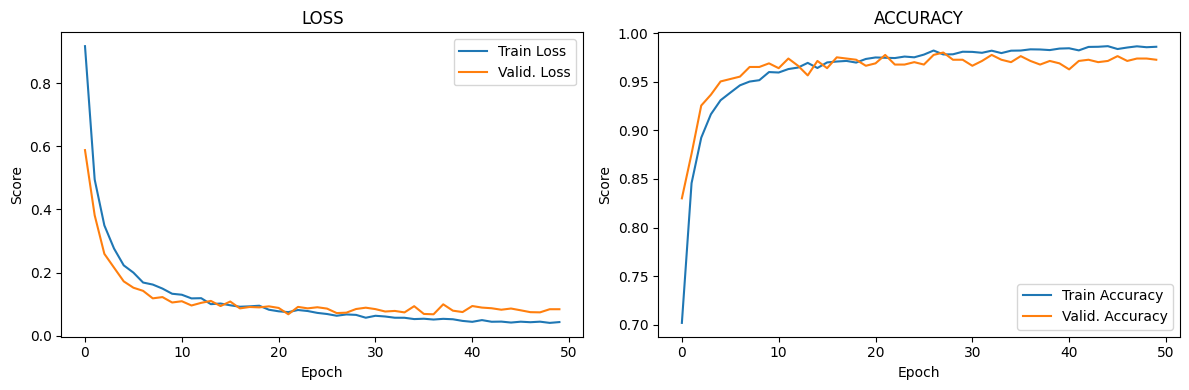

In [ ]:
plot_performance(result)

In [ ]:
def test_accuracy(model, test_loader, device):
    """
    Fungsi untuk menghitung akurasi model pada data uji.

    Args:
        model: Model PyTorch yang telah dilatih.
        test_loader: DataLoader untuk data uji.
        device: Perangkat yang digunakan untuk menjalankan model (CPU atau GPU).

    Returns:
        float: Akurasi model pada data uji.
    """
    model.eval()  # Set model ke mode evaluasi
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f"Akurasi pada data uji: {accuracy:.2f}%")
    return accuracy

# Panggil fungsi test_accuracy untuk menghitung akurasi pada data uji
test_accuracy(model, test_loader, device)

Akurasi pada data uji: 96.78%


96.78217821782178

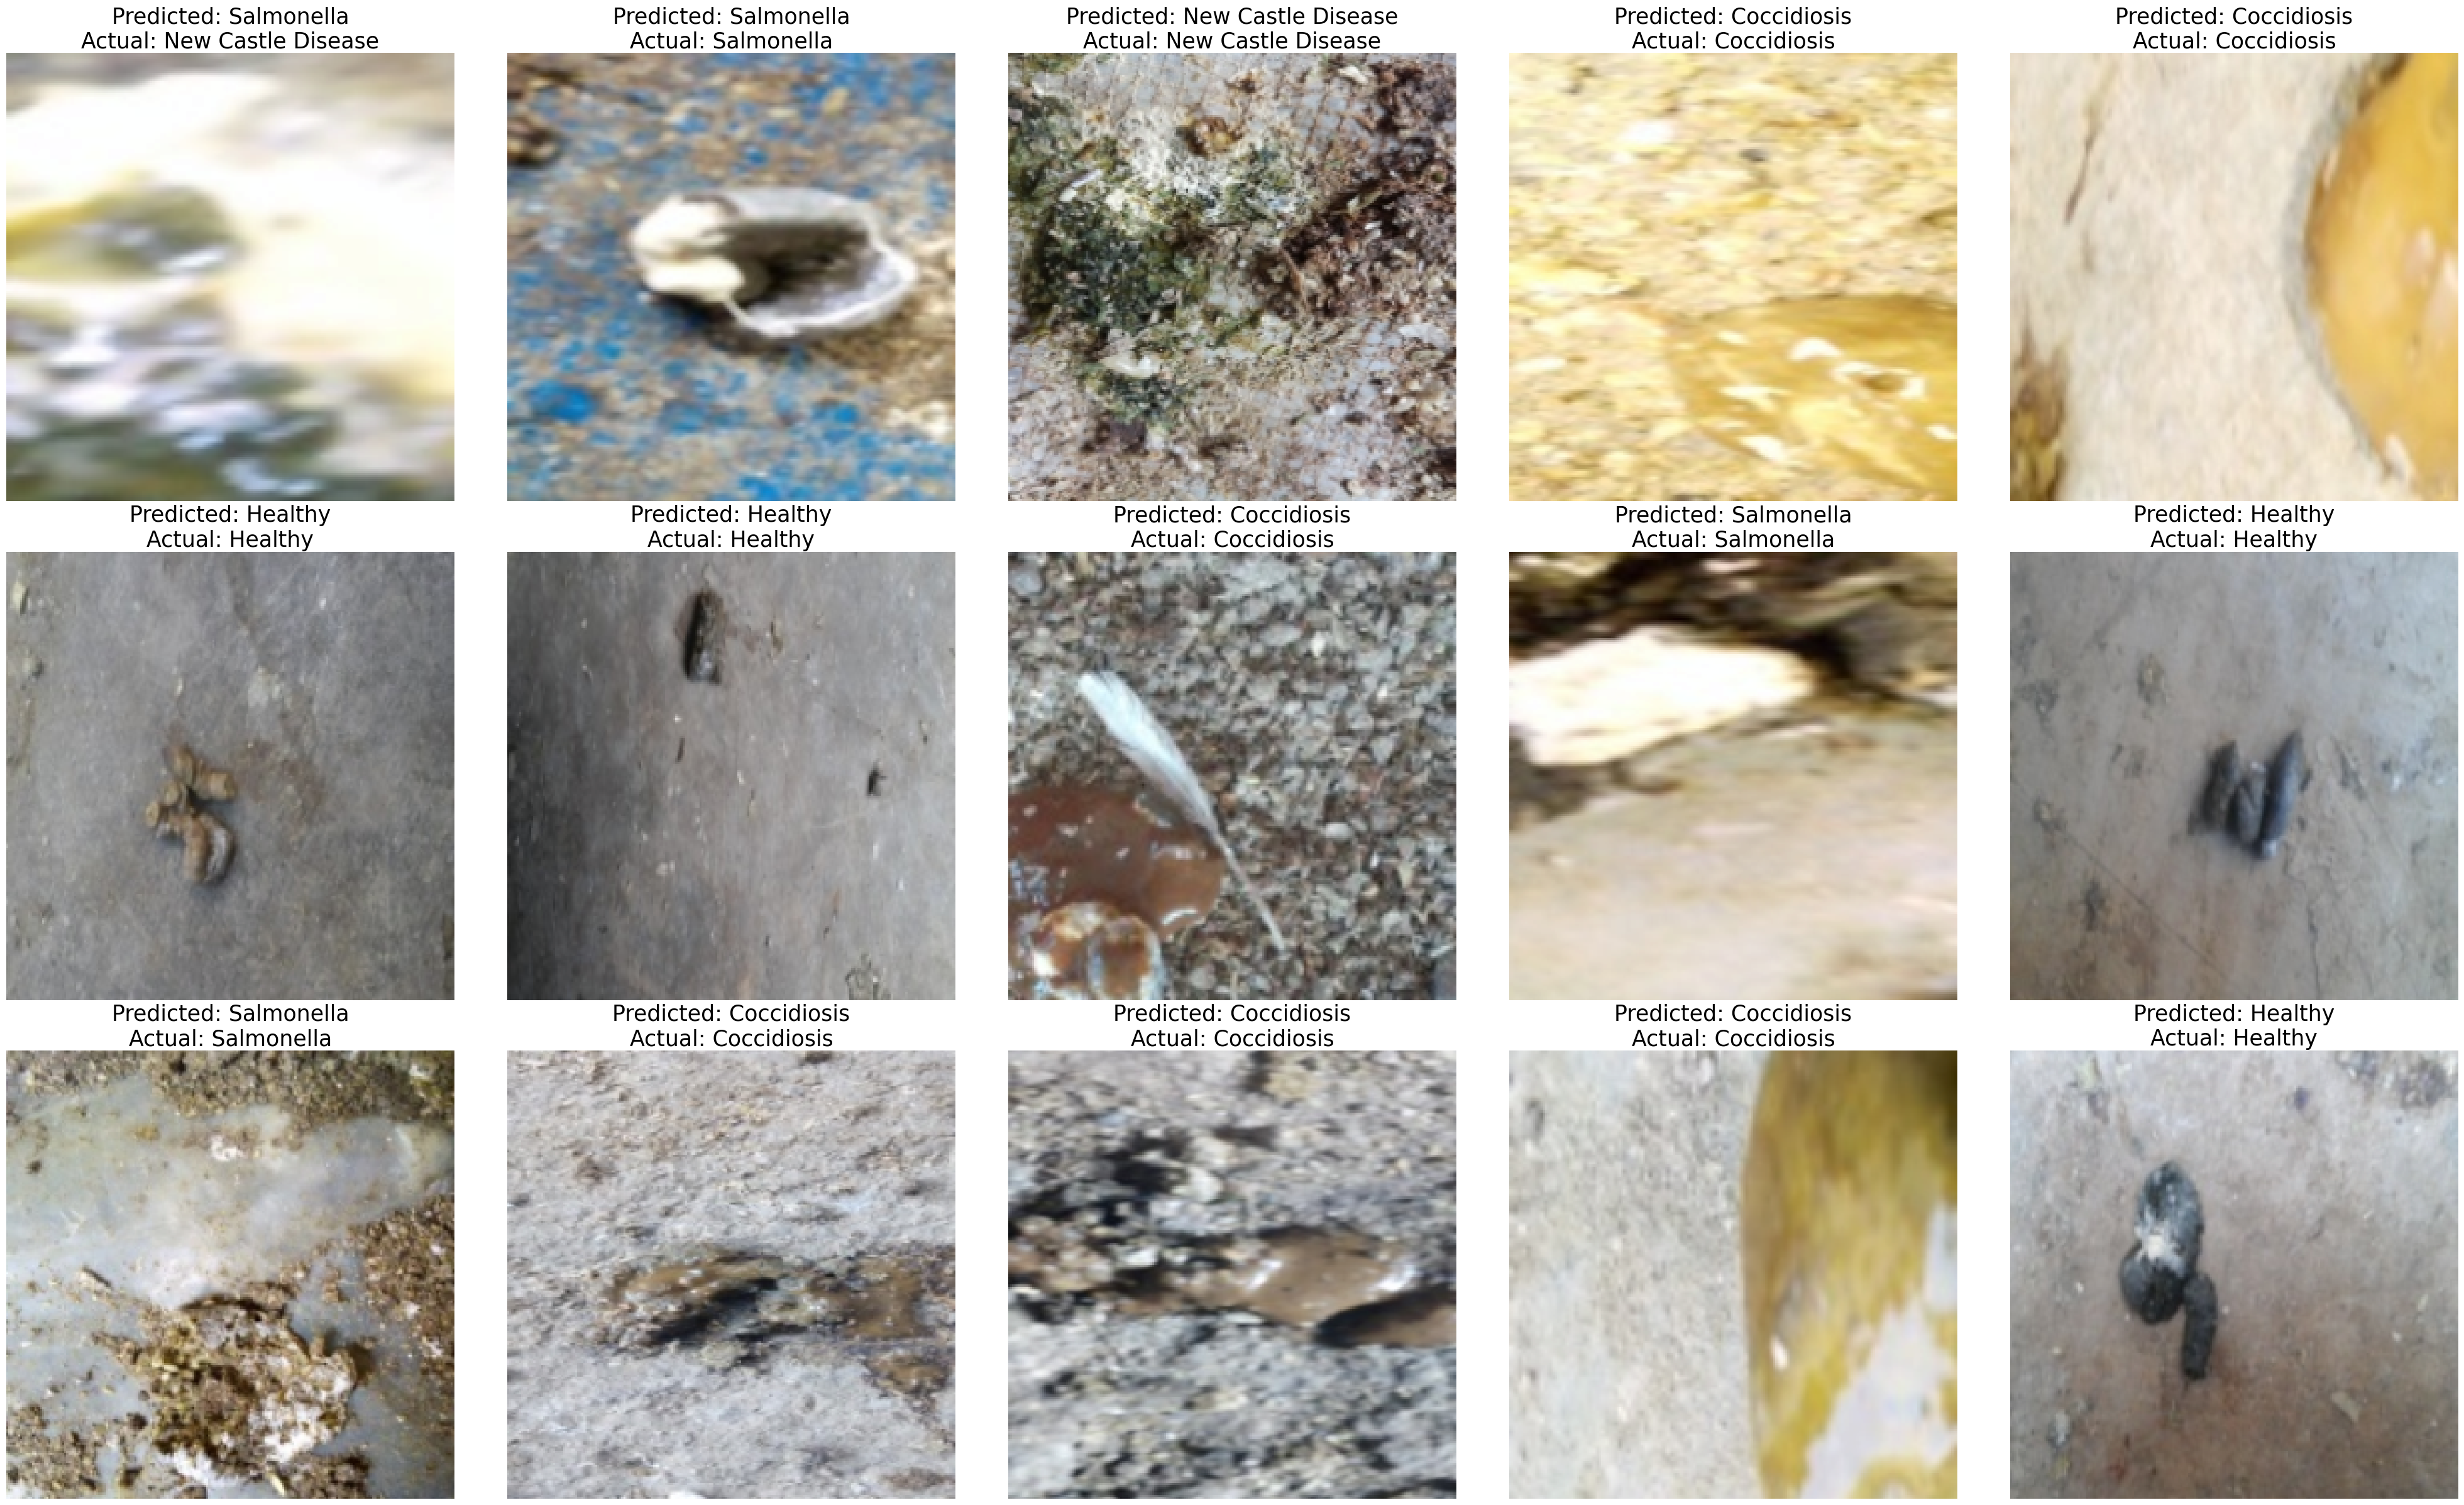

In [ ]:
def visualize_predictions(model, test_loader, device, num_images=15, figsize_per_image=(8, 8), title_fontsize=25):
  """
  Visualizes predictions of a model on a specified number of images from the test loader.

  Args:
    model: The trained model.
    test_loader: The DataLoader for the test set.
    device: The device (CPU or GPU) to use for the model.
    num_images: The number of images to visualize.
    figsize_per_image: Tuple (width, height) specifying the size of each image subplot.
    title_fontsize: Font size for the subplot titles.
  """

  model.eval()  # Set the model to evaluation mode

  class_names = {
      0: 'Healthy',
      1: 'Salmonella',
      2: 'Coccidiosis',
      3: 'New Castle Disease'
  }

  # Calculate the number of rows and columns for subplots
  num_rows = int(np.ceil(num_images / 5))  # Calculate rows dynamically based on num_images

  # Calculate total figure size based on individual image size and grid dimensions
  fig_width = figsize_per_image[0] * 5  # 5 columns
  fig_height = figsize_per_image[1] * num_rows

  plt.figure(figsize=(fig_width, fig_height))
  with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
      if i >= num_images:
        break

      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      for j in range(images.shape[0]):
        if j >= num_images: # break if number of images exceeds num_images
          break

        plt.subplot(num_rows, 5, j+1) # Use num_rows here
        img = images[j].cpu().numpy().transpose((1, 2, 0))
        # Denormalize the image
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = std * img + mean
        img = np.clip(img, 0, 1)  # Ensure pixel values are within the valid range
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {class_names[predicted[j].item()]}\nActual: {class_names[labels[j].item()]}", fontsize=title_fontsize)

      plt.tight_layout()
      plt.show()
      break


# Assuming you have your trained model, test_loader, and device
visualize_predictions(model, test_loader, device, figsize_per_image=(8, 8), title_fontsize=25)  # Example: Set each image to 8x8 inches and font size to 25

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       252
           1       0.96      0.98      0.97       260
           2       0.99      0.97      0.98       231
           3       0.98      0.95      0.97        65

    accuracy                           0.97       808
   macro avg       0.97      0.96      0.97       808
weighted avg       0.97      0.97      0.97       808



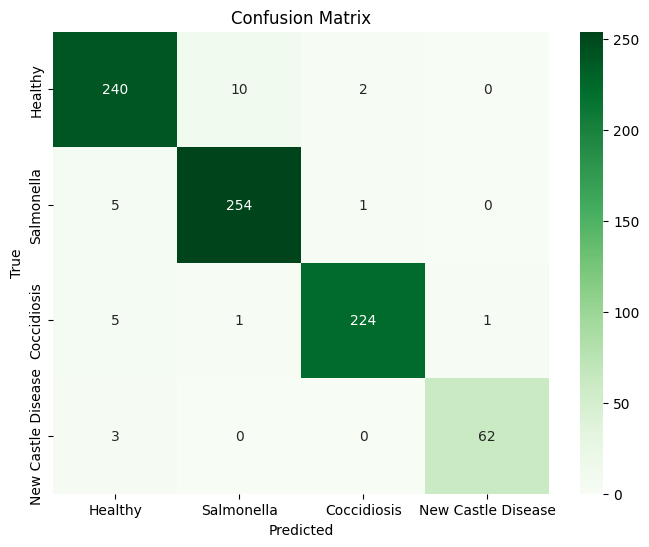

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluates the performance of a trained PyTorch model on a test dataset.
    Args:
        model: The trained PyTorch model.
        test_loader: DataLoader for the test dataset.
        device: The device (CPU or GPU) where the model is running.
    Returns:
        None
    """
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    print(classification_report(all_labels, all_predictions))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=['Healthy', 'Salmonella', 'Coccidiosis', 'New Castle Disease'],
                yticklabels=['Healthy', 'Salmonella', 'Coccidiosis', 'New Castle Disease'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Assuming you have your trained model, test_loader, and device
evaluate_model(model, test_loader, device)

In [ ]:
torch.save(model.state_dict(), 'model_final.pth')

Upload gambar

In [ ]:
def upload_image_colab():
    uploaded = files.upload()
    # Memproses file yang diunggah
    if uploaded:
        for file_name in uploaded.keys():
            print(f"Gambar yang diunggah: {file_name}")
            # Membuka dan menampilkan gambar
            image = Image.open(file_name)
            return image, file_name
    else:
        print("Tidak ada file yang diunggah.")
        return None,


Predict gambar yang di upload

Saving pcrncd.jpg to pcrncd.jpg
Gambar yang diunggah: pcrncd.jpg


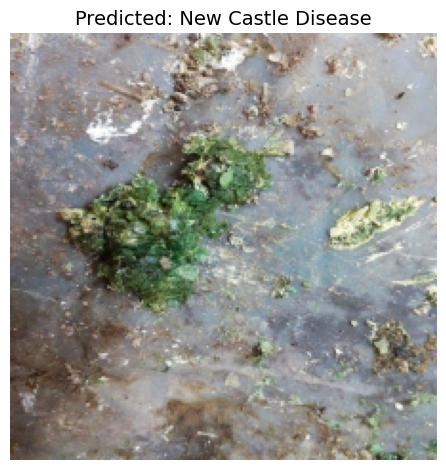

In [ ]:
def uploaded_predictions(model, image, device='cpu', title_fontsize=12):

  model.eval()  # Set the model to evaluation mode
  model.to(device)

  class_names = {
      0: 'Healthy',
      1: 'Salmonella',
      2: 'Coccidiosis',
      3: 'New Castle Disease'
  }

  # Transformasi gambar untuk input ke model
  transform = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize gambar ke 224x224
      transforms.ToTensor(),  # Konversi ke tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisasi
  ])

  # Transformasi dan tambahkan dimensi batch
  input_image = transform(image).unsqueeze(0)

  # Prediksi menggunakan model
  with torch.no_grad():
      output_predict = model(input_image)
      _, predicted = torch.max(output_predict, 1)

  predicted_class = class_names[predicted.item()]

  # Menampilkan gambar dan prediksi
  img = np.array(image) / 255.0  # Konversi gambar ke rentang [0, 1]
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"Predicted: {class_names[predicted.item()]}", fontsize=title_fontsize)
  plt.tight_layout()
  plt.show()

  return predicted_class

image, image_name = upload_image_colab()

if image:
    predicted_class = uploaded_predictions(model, image, title_fontsize=14)
else:
    print("Tidak ada gambar yang dapat diprediksi.")

API GPT dari hasil predict

In [ ]:
!pip install langchain-openai
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.19
    Uninstalling langchain-core-0.3.19:
      Successfully uninstalled langchain-core-0.3.19


In [ ]:
from langchain_openai import ChatOpenAI
import openai
import os

In [ ]:
# Ganti 'xxx' jadi API Key asli sebelum run program
os.environ['OPENAI_API_KEY'] = 'xxx'
openai.api_key = os.environ['OPENAI_API_KEY']

In [ ]:
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.8,
    max_tokens=None,
    timeout=None,
    max_retries=3
)

Input Prompt GPT menyesuaikan hasil predict

In [ ]:
def prompting_predict(predicted_class):
  valid_classes = ["Healthy", "Salmonella", "Coccidiosis", "New Castle Disease"]

  # Cek apakah predicted_class termasuk dalam kelas yang valid
  if predicted_class not in valid_classes:
    print("Predicted class tidak valid. Lakukan prediksi terlebih dahulu.")
    return

  prompt_class = {
    "Healthy": "Ayam Anda dalam keadaan sehat. Apa yang ingin Anda tanyakan tentang perawatan ayam sehat?",
    "Salmonella": "Ayam Anda terindikasi Salmonella. Apa yang ingin Anda ketahui tentang cara penanganan dan pencegahannya?",
    "Coccidiosis": "Ayam Anda terindikasi Coccidiosis. Apakah Anda ingin mengetahui lebih lanjut tentang gejala dan pengobatannya?",
    "New Castle Disease": "Ayam Anda terindikasi terkena New Castle Disease. Bagaimana kami dapat membantu Anda mengelola penyakit ini?"
  }

  # Daftar opsi pertanyaan per kategori
  q_options = {
      "Healthy": [
          "1. Apa makanan terbaik untuk ayam sehat?",
          "2. Bagaimana menjaga kebersihan kandang?",
          "3. Apa vaksin yang direkomendasikan untuk ayam sehat?"
      ],
      "Salmonella": [
          "1. Apa gejala Salmonella pada ayam?",
          "2. Bagaimana cara mengobati Salmonella?",
          "3. Apakah Salmonella bisa dicegah dengan vaksin?"
      ],
      "Coccidiosis": [
          "1. Apa tanda-tanda Coccidiosis?",
          "2. Bagaimana cara mencegah Coccidiosis?",
          "3. Obat apa yang efektif untuk Coccidiosis?"
      ],
      "New Castle Disease": [
          "1. Apa gejala utama New Castle Disease?",
          "2. Bagaimana cara menghentikan penyebaran penyakit ini?",
          "3. Apakah ada vaksin untuk New Castle Disease?"
      ]
  }

  first_qst = True
  while True:
    if first_qst:
      print(prompt_class.get(predicted_class))
      print("Silakan pilih salah satu pertanyaan berikut untuk membantu kami memberikan informasi yang Anda butuhkan:")
      for question in q_options .get(predicted_class, []):
        print(question)
      print("4. Lainnya")
      print("5. Keluar")

      user_choice = input("Masukkan nomor opsi: ")
      if user_choice.isdigit():  # Mengecek apakah input adalah angka
        if user_choice in ["1", "2", "3"]:
          question_index = int(user_choice) - 1
          selected_question = "Jawab seakan anda adalah expert di bidang kesehatan hewan." + q_options[predicted_class][question_index] + "Jawab pertanyaan ini, hanya jika pertanyaan relevan dengan kesehatan dan perawatan ayam."
          output_text = llm.invoke(selected_question)
          print(output_text.content)
        elif user_choice == "4":
          manual_question = input("\nSilakan tulis pertanyaan Anda: ")
          manual_question = "Jawab seakan anda adalah expert di bidang kesehatan hewan." + manual_question + "Jawab pertanyaan ini, hanya jika pertanyaan relevan dengan kesehatan dan perawatan ayam."
          output_text = llm.invoke(manual_question)
          print(output_text.content)
        elif user_choice == "5":
          print("Terima kasih telah menggunakan layanan kami.")
          break
        else:
          print("\nPilihan tidak valid. Silakan coba lagi.")
      else:
        print("\nInput harus berupa angka. Silakan coba lagi.")
    else:
      print("\nMasukkan pertanyaan Anda atau ketik 'keluar' untuk menyelesaikan: ")
      manual_question = input("Pertanyaan: ")
      if manual_question.lower() == "keluar":
        print("Terima kasih telah menggunakan layanan kami.")
        break
      else:
        manual_question = "Jawab seakan anda adalah expert di bidang kesehatan hewan." + manual_question + "Jawab pertanyaan ini, hanya jika pertanyaan relevan dengan kesehatan dan perawatan ayam."
        output_text = llm.invoke(manual_question)
        print(output_text.content)
    first_qst = False

prompting_predict(predicted_class)

Ayam Anda terindikasi terkena New Castle Disease. Bagaimana kami dapat membantu Anda mengelola penyakit ini?
Silakan pilih salah satu pertanyaan berikut untuk membantu kami memberikan informasi yang Anda butuhkan:
1. Apa gejala utama New Castle Disease?
2. Bagaimana cara menghentikan penyebaran penyakit ini?
3. Apakah ada vaksin untuk New Castle Disease?
4. Lainnya
5. Keluar
Masukkan nomor opsi: 7

Pilihan tidak valid. Silakan coba lagi.

Masukkan pertanyaan Anda atau ketik 'keluar' untuk menyelesaikan: 
Pertanyaan: 4
Tentu, saya siap membantu dengan pertanyaan seputar kesehatan dan perawatan ayam. Silakan ajukan pertanyaan Anda!

Masukkan pertanyaan Anda atau ketik 'keluar' untuk menyelesaikan: 
Pertanyaan: presiden indonesia sekarang?
Saya minta maaf, saya hanya dapat menjawab pertanyaan yang relevan dengan kesehatan dan perawatan ayam. Jika Anda memiliki pertanyaan terkait topik tersebut, silakan ajukan, dan saya akan dengan senang hati membantu Anda.

Masukkan pertanyaan Anda atau 

Newcastle Disease (ND) adalah penyakit viral yang sangat menular pada unggas, termasuk ayam. Sayangnya, tidak ada obat spesifik yang dapat menyembuhkan ayam yang terinfeksi Newcastle Disease. Penanganan utama terhadap ND adalah melalui pencegahan dan pengelolaan, bukan pengobatan setelah infeksi terjadi. Berikut adalah beberapa langkah yang dapat diambil:

1. **Vaksinasi**: Vaksinasi merupakan cara paling efektif untuk mencegah Newcastle Disease. Vaksin hidup atau inaktif dapat digunakan, tergantung pada kondisi dan kebutuhan spesifik.

2. **Biosekuriti**: Menerapkan langkah-langkah biosekuriti yang ketat sangat penting untuk mencegah penyebaran virus. Ini termasuk pembatasan akses ke area peternakan, sanitasi yang baik, dan kontrol terhadap peralatan serta kendaraan yang masuk dan keluar dari lokasi.

3. **Pengelolaan Kandang**: Menjaga kebersihan kandang dan memastikan ventilasi yang baik dapat membantu mengurangi stres pada ayam, yang pada gilirannya dapat meningkatkan ketahanan tubuh mereka terhadap infeksi.

4. **Isolasi dan Karantina**: Ayam yang terinfeksi harus segera diisolasi untuk mencegah penularan lebih lanjut. Praktik karantina untuk ayam baru juga penting sebelum mencampurkannya dengan kawanan yang ada.

5. **Dukungan Nutrisi**: Memberikan nutrisi yang baik dapat membantu memperkuat sistem imun ayam dan mendukung pemulihan pada ayam yang terinfeksi atau mengalami stres.

Jika ada tanda-tanda infeksi Newcastle Disease, sangat penting untuk segera berkonsultasi dengan dokter hewan untuk mendapatkan saran dan tindakan lebih lanjut. Penyakit ini bisa menyebabkan kerugian ekonomi yang signifikan dan memerlukan manajemen yang tepat.
